In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from itertools import product
from datetime import datetime
    

In [10]:
pod_names = [
    "adservice", "cartservice", "checkoutservice", "currencyservice", "emailservice", "frontend", "paymentservice", "productcatalogservice", "recommendationservice", "redis-cart", "shippingservice",
]
df = pd.read_csv("../data/pod_metrics.csv", index_col="timestamp")
df.head()

,adservice-cpu,cartservice-cpu,checkoutservice-cpu,currencyservice-cpu,emailservice-cpu,frontend-cpu,paymentservice-cpu,productcatalogservice-cpu,recommendationservice-cpu,redis-cart-cpu,...,cartservice-mem,checkoutservice-mem,currencyservice-mem,emailservice-mem,frontend-mem,paymentservice-mem,productcatalogservice-mem,recommendationservice-mem,redis-cart-mem,shippingservice-mem
timestamp,,,,,,,,,,,,,,,,,,,,,
1708456108,0.005770,0.009804,0.004412,0.054043,0.004566,0.035063,0.004084,0.018532,0.010961,0.004230,...,3.497235e+06,1.220570e+06,2.953577e+06,1.858798e+06,2.497851e+06,1.498199e+06,2.420674e+06,2.202928e+06,1.453671e+06,1.072344e+06
1708457008,0.005713,0.009834,0.004423,0.053978,0.004565,0.035026,0.004094,0.018585,0.011002,0.004234,...,3.530800e+06,1.231450e+06,2.987614e+06,1.941651e+06,2.476625e+06,1.474011e+06,2.422124e+06,2.241454e+06,1.429042e+06,1.126998e+06
1708457908,0.005732,0.009870,0.004449,0.054170,0.004560,0.035224,0.004105,0.018699,0.011058,0.004236,...,3.497327e+06,1.173848e+06,3.004953e+06,1.858314e+06,2.475417e+06,1.447712e+06,2.461103e+06,2.258756e+06,1.408040e+06,1.158933e+06
1708458808,0.005620,0.009884,0.004496,0.054039,0.004562,0.035208,0.004135,0.018715,0.011076,0.004231,...,3.533311e+06,1.160097e+06,2.956337e+06,1.876444e+06,2.448261e+06,1.481015e+06,2.458037e+06,2.260507e+06,1.427296e+06,1.084322e+06
1708459708,0.005597,0.009891,0.004513,0.054827,0.004528,0.035048,0.004138,0.018608,0.011018,0.004238,...,3.555899e+06,1.161273e+06,2.929072e+06,1.798997e+06,2.402290e+06,1.560420e+06,2.439235e+06,2.332465e+06,1.436667e+06,1.084144e+06


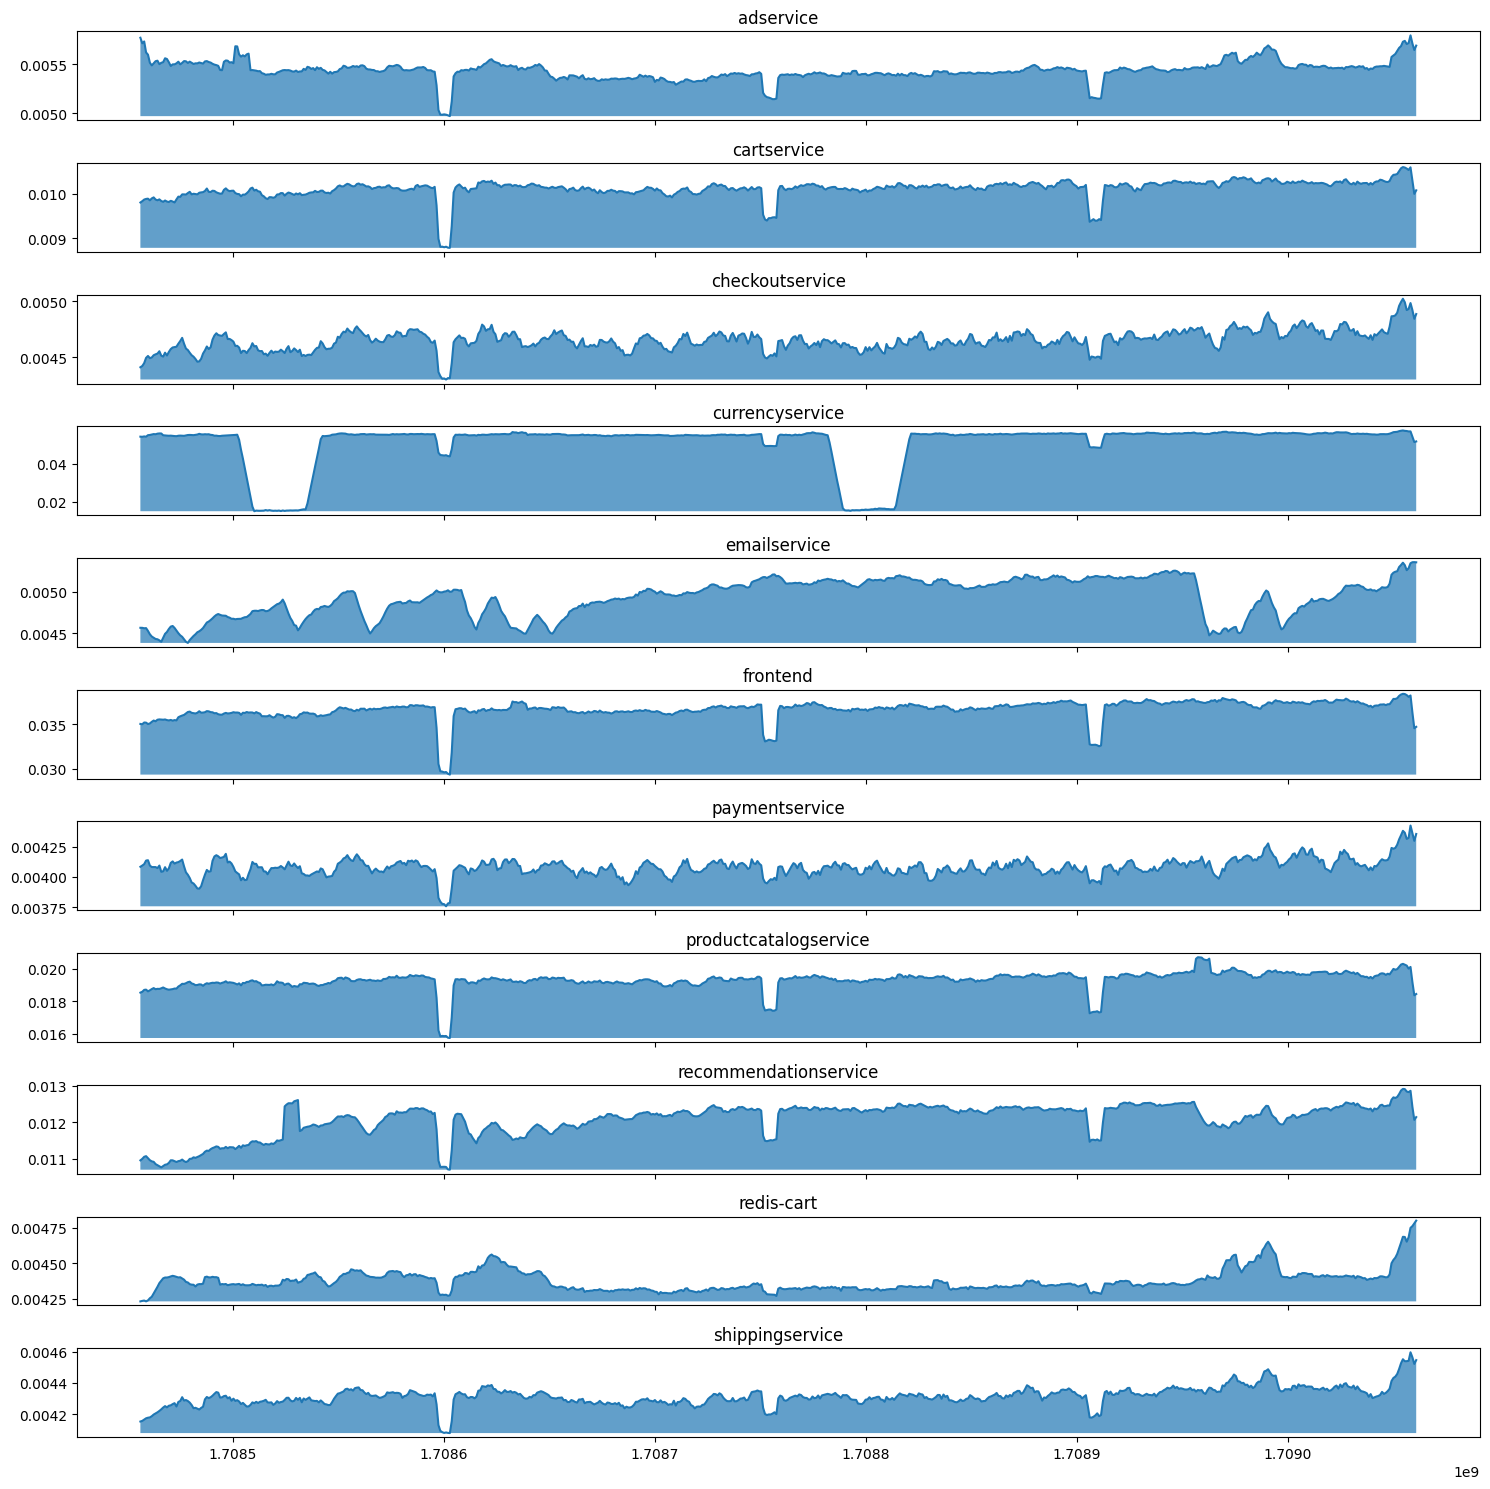

In [36]:
fig, axs = plt.subplots(11, figsize=(15, 15), sharex=True)
sample = df.sort_index()

for i, pod in enumerate(pod_names):
    axs[i].plot(sample.index, sample[f"{pod}-cpu"])
    axs[i].fill_between(sample.index, sample[f"{pod}-cpu"].min(), sample[f"{pod}-cpu"], alpha=0.7)
    axs[i].set_title(pod)

plt.tight_layout()
plt.savefig("img/CPU usage.png", dpi=360, transparent=True)

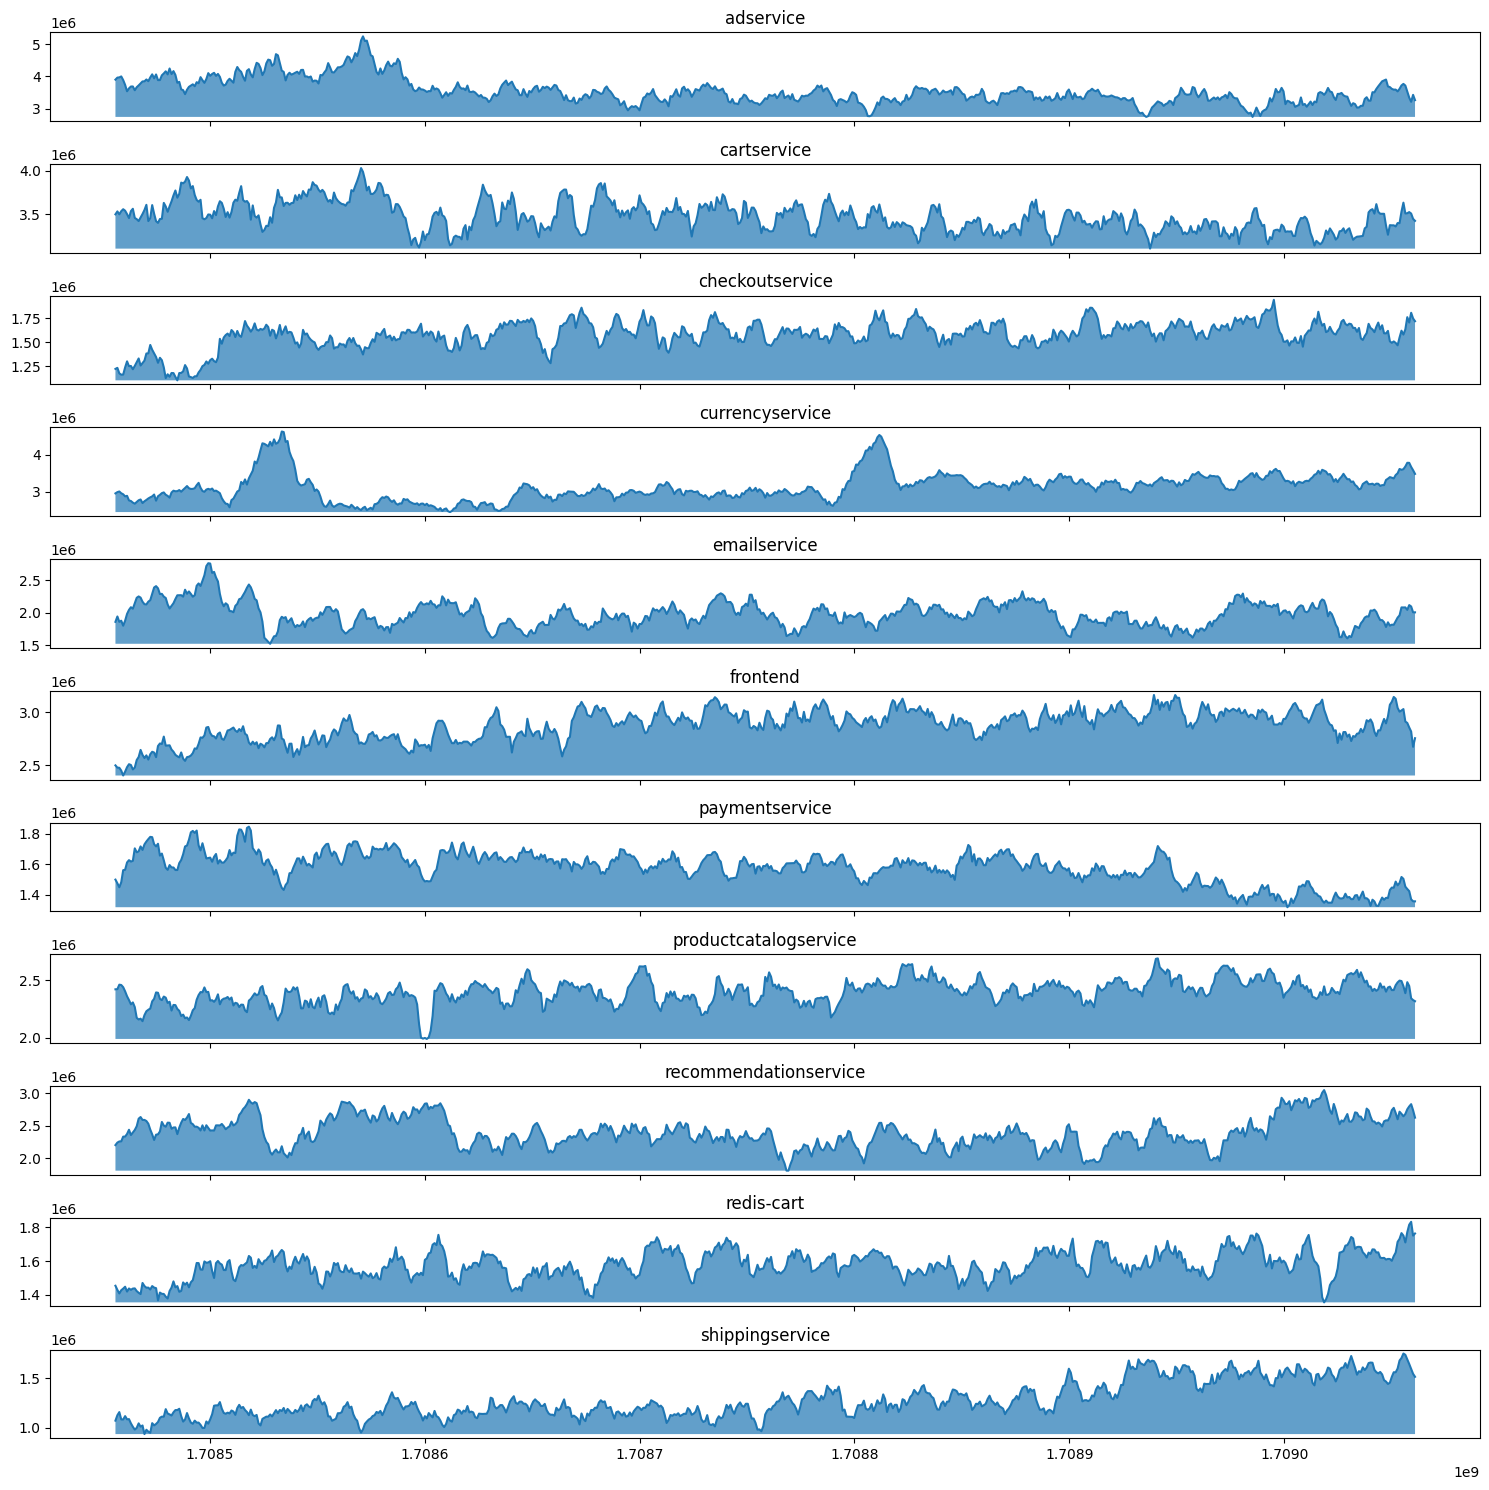

In [35]:
fig, axs = plt.subplots(11, figsize=(15, 15), sharex=True)
sample = df.sort_index()

for i, pod in enumerate(pod_names):
    axs[i].plot(sample.index, sample[f"{pod}-mem"])
    axs[i].fill_between(sample.index, sample[f"{pod}-mem"].min(), sample[f"{pod}-mem"], alpha=0.7)
    axs[i].set_title(pod)

plt.tight_layout()
plt.savefig("img/RAM usage.png", dpi=360, transparent=True)

In [26]:
df_graph = pd.read_csv("../data/pod_requests.csv")
df_graph.head(10)

,timestamp,from,to,value
0,1708456108,frontend,adservice,3.033253
1,1708457008,frontend,adservice,3.036454
2,1708457908,frontend,adservice,3.047171
3,1708458808,frontend,adservice,3.035619
4,1708459708,frontend,adservice,3.003884
5,1708460608,frontend,adservice,2.999709
6,1708461508,frontend,adservice,2.999460
7,1708462408,frontend,adservice,3.017408
8,1708463308,frontend,adservice,3.003624
9,1708464208,frontend,adservice,3.014492


In [27]:
df_timed_graph = df_graph.groupby("timestamp")

selected_t = np.random.choice(df_graph["timestamp"].unique(), 6)
selected_t.sort()

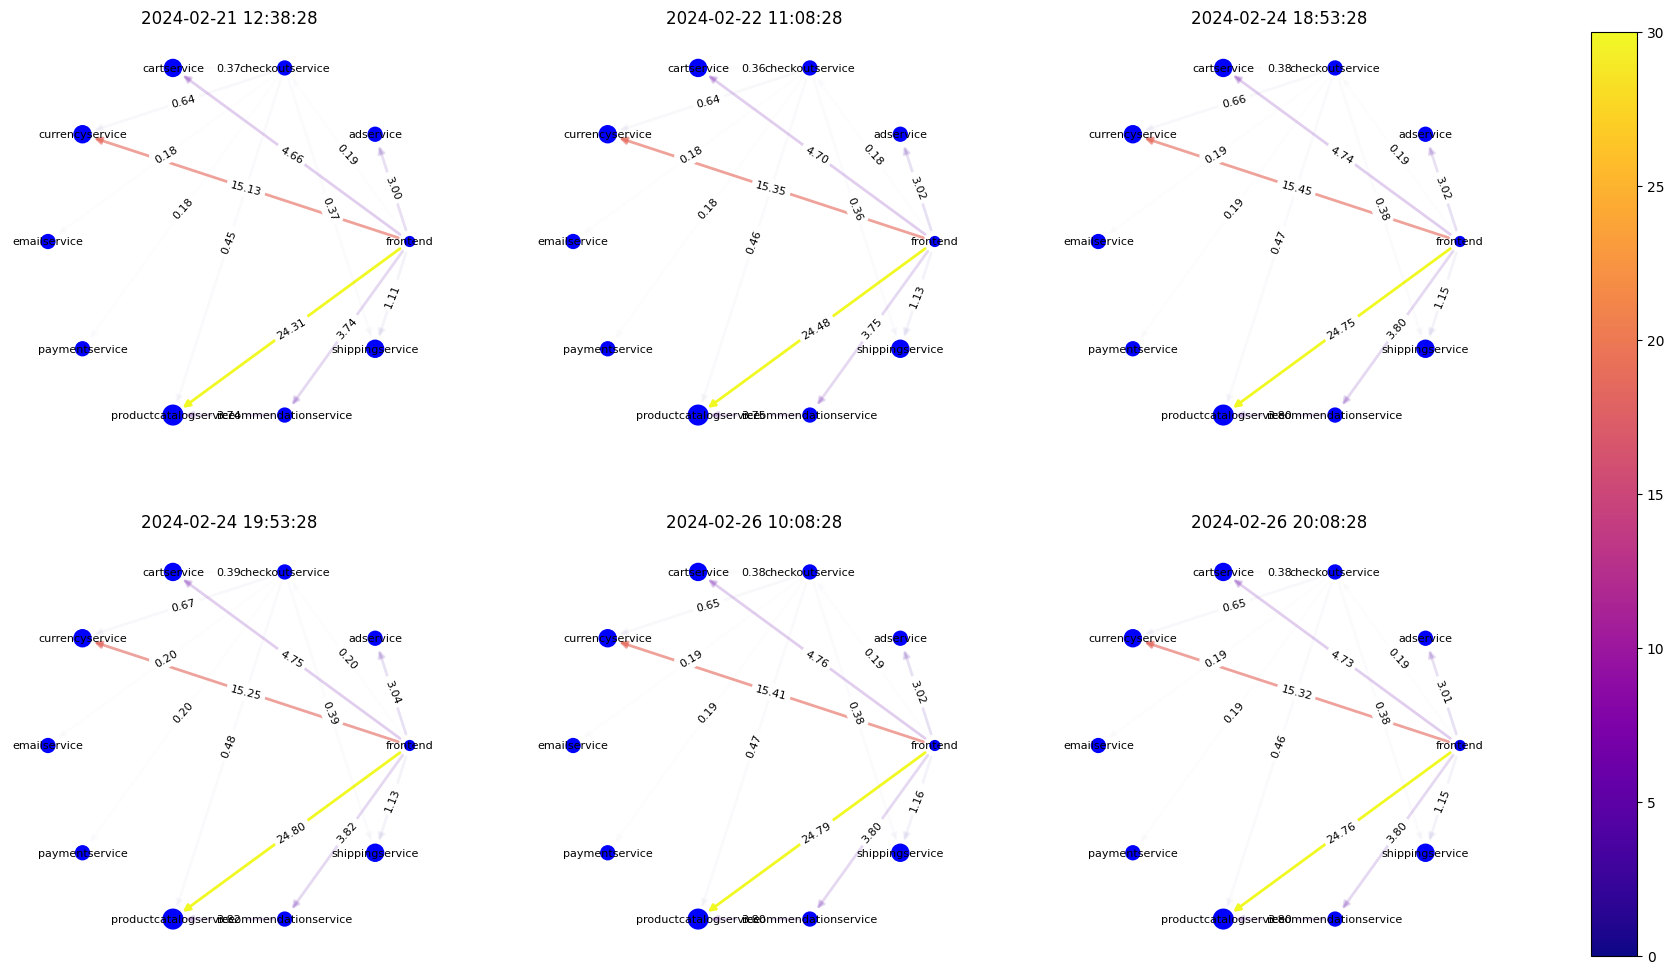

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12), sharex=True)

for i, j in product(range(2), range(3)):
    plt.sca(axs[i, j])
    date = selected_t[i * 3 + j]
    
    t_timed_graph = df_timed_graph.get_group(date)
    G = nx.DiGraph()
    for idx, row in t_timed_graph.iterrows():
        G.add_edge(row["from"],  row["to"], weight=row["value"])
        
    pos = nx.circular_layout(G)
    node_sizes = 50 * (np.array(list(dict(G.in_degree).values())) + 1)
    edge_weights = np.array(list(nx.get_edge_attributes(G, "weight").values()))
    edges_alphas = edge_weights / edge_weights.max()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
    edges = nx.draw_networkx_edges(G, pos, width=2, edge_cmap=plt.colormaps["plasma"], edge_color=edge_weights)
    
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    for k, edge in enumerate(edges):
        edge.set_alpha(edges_alphas[k])
    
    axs[i, j].set_title(datetime.fromtimestamp(date), fontsize=12)
    axs[i, j].set_axis_off()

sm = plt.cm.ScalarMappable(cmap=plt.colormaps["plasma"], norm=plt.Normalize(vmin=0, vmax=30))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs.ravel().tolist())
plt.savefig("img/Microservice graph.png", dpi=360, transparent=True)